In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json






In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors


In [ ]:
from glob import glob
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Dataset path and class labels
DATASET_PATH = "/content/dataset/COVID-19_Radiography_Dataset"
CLASSES = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Load all image paths and corresponding labels
all_images = []
all_labels = []

for label in CLASSES:
    folder = os.path.join(DATASET_PATH, label, "images")
    images = glob(folder + "/*")  # Accepts .png, .jpg, etc.
    all_images.extend(images)
    all_labels.extend([label] * len(images))

# Print count per class
for c in CLASSES:
    count = sum(1 for l in all_labels if l == c)
    print(f"{c}: {count} images")

# Encode labels
label_to_index = {label: i for i, label in enumerate(CLASSES)}
encoded_labels = [label_to_index[label] for label in all_labels]

# First split: Train (70%) and Temp (30% -> val+test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_images, encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42)

# Second split: Validation (15%) and Test (15%) from Temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Final output
print(f"✅ Train size: {len(train_paths)}")
print(f"✅ Validation size: {len(val_paths)}")
print(f"✅ Test size: {len(test_paths)}")


COVID: 3616 images
Lung_Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images
✅ Train size: 14815
✅ Validation size: 3175
✅ Test size: 3175


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64

def path_to_dataset(image_paths, labels):
    def _load(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = tf.cast(image, tf.float32) / 255.0  # Normalize
        return image, tf.one_hot(label, depth=4)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

# Datasets
train_ds = path_to_dataset(train_paths, train_labels).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = path_to_dataset(val_paths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = path_to_dataset(test_paths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Geler le backbone sauf les 2 dernières couches
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Ajout des nouvelles couches
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,841,156 (7.02 MB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [ ]:
print("Total parameters:", model.count_params())


Total parameters: 4096580


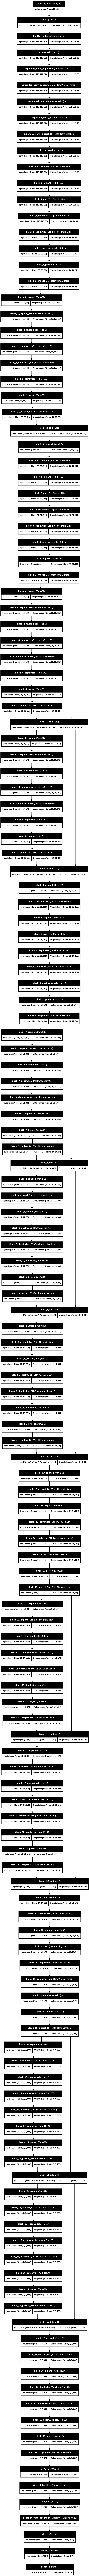

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_model(train_ds, val_ds, mode='fc_only', epochs=20, lr=0.001):
    print(f"Mode d'entraînement : {mode}")

    # Charger MobileNetV2 avec poids ImageNet
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Définir les couches à entraîner selon le mode
    if mode == 'fc_only':
        for layer in base_model.layers:
            layer.trainable = False
    elif mode == 'conv1_fc':
        for layer in base_model.layers[:-1]:
            layer.trainable = False
        base_model.layers[-1].trainable = True
    elif mode == 'conv2_fc':
        for layer in base_model.layers[:-2]:
            layer.trainable = False
        base_model.layers[-2].trainable = True
        base_model.layers[-1].trainable = True
    else:
        raise ValueError("Mode invalide : choisir parmi 'fc_only', 'conv1_fc', ou 'conv2_fc'")

    # Ajouter les couches FC personnalisées
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True)

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time

    print(f"Temps d'entraînement ({mode}) : {training_time:.2f} secondes")
    return model, history, training_time


In [ ]:
model_fc, history_fc, time_fc = build_and_train_model(train_ds, val_ds, mode='fc_only')


Mode d'entraînement : fc_only
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 62s 204ms/step - accuracy: 0.7324 - loss: 0.7473 - val_accuracy: 0.8598 - val_loss: 0.3733
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.8717 - loss: 0.3367 - val_accuracy: 0.8750 - val_loss: 0.3286
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.8937 - loss: 0.2809 - val_accuracy: 0.8658 - val_loss: 0.3549
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 35s 144ms/step - accuracy: 0.9074 - loss: 0.2481 - val_accuracy: 0.8778 - val_loss: 0.3343
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.9172 - loss: 0.2200 - val_accuracy: 0.8860 - val_loss: 0.3220
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.9267 - loss: 0.1954 - val_accuracy: 0.8942 - val_loss: 0.3120
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 148ms/step - accuracy: 0.9304 - loss: 0.1832 - val_accuracy: 0.8850 - val_loss: 0.3526
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/ste

In [ ]:
model_c1, history_c1, time_c1 = build_and_train_model(train_ds, val_ds, mode='conv1_fc')


Mode d'entraînement : conv1_fc
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 54s 188ms/step - accuracy: 0.7764 - loss: 0.6342 - val_accuracy: 0.8227 - val_loss: 0.4682
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.8690 - loss: 0.3459 - val_accuracy: 0.8806 - val_loss: 0.3195
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.8967 - loss: 0.2807 - val_accuracy: 0.8661 - val_loss: 0.3479
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - accuracy: 0.9088 - loss: 0.2401 - val_accuracy: 0.8643 - val_loss: 0.3771
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.9177 - loss: 0.2211 - val_accuracy: 0.8668 - val_loss: 0.3615
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.9240 - loss: 0.2023 - val_accuracy: 0.8769 - val_loss: 0.3356
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.9269 - loss: 0.1858 - val_accuracy: 0.8876 - val_loss: 0.3308
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/st

In [ ]:
model_c2, history_c2, time_c2 = build_and_train_model(train_ds, val_ds, mode='conv2_fc')


Mode d'entraînement : conv2_fc
Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 53s 183ms/step - accuracy: 0.7871 - loss: 0.5781 - val_accuracy: 0.8195 - val_loss: 0.5280
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8805 - loss: 0.3168 - val_accuracy: 0.8246 - val_loss: 0.5674
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.9021 - loss: 0.2568 - val_accuracy: 0.8211 - val_loss: 0.5100
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 75s 146ms/step - accuracy: 0.9126 - loss: 0.2315 - val_accuracy: 0.8643 - val_loss: 0.3932
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - accuracy: 0.9256 - loss: 0.1952 - val_accuracy: 0.8652 - val_loss: 0.3917
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9321 - loss: 0.1803 - val_accuracy: 0.8838 - val_loss: 0.3675
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9426 - loss: 0.1502 - val_accuracy: 0.8898 - val_loss: 0.3561
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/st

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(histories, labels):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f"{label} - train")
        plt.plot(history.history['val_accuracy'], label=f"{label} - val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f"{label} - train")
        plt.plot(history.history['val_loss'], label=f"{label} - val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


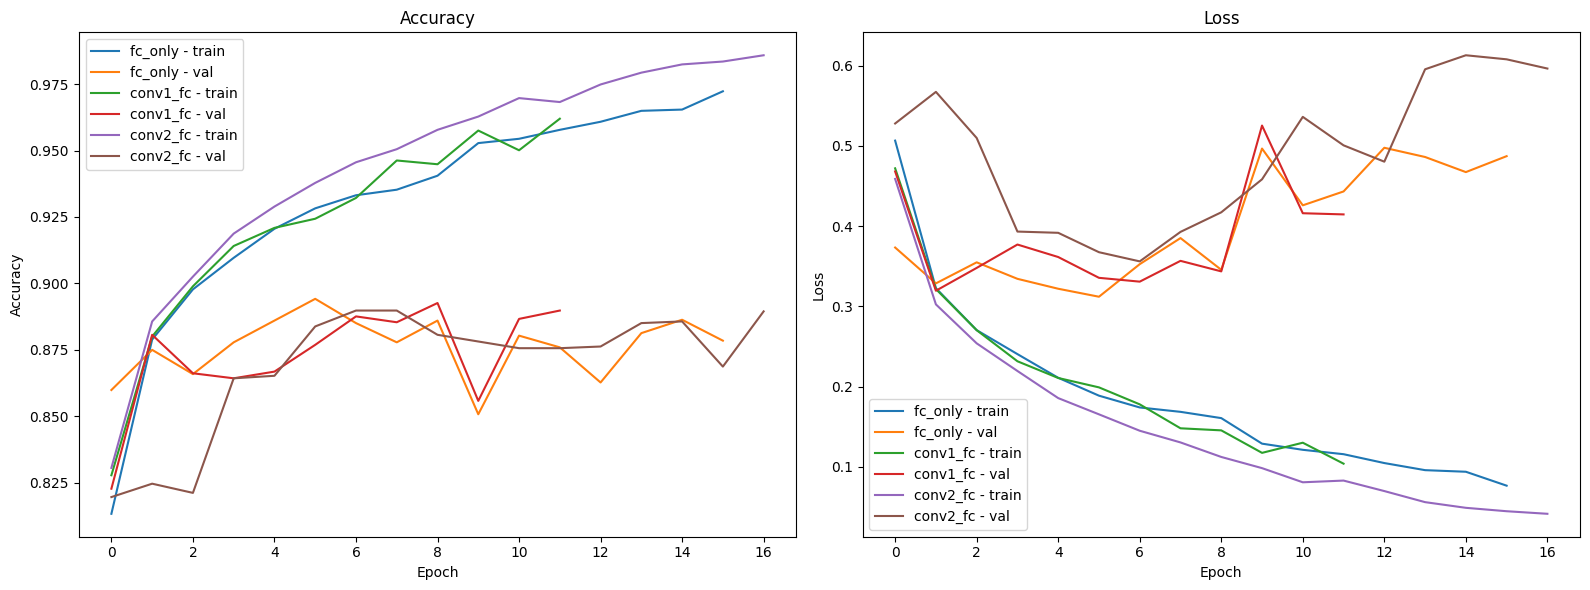

In [ ]:
plot_training_curves(
    [history_fc, history_c1, history_c2],
    ['fc_only', 'conv1_fc', 'conv2_fc']
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, dataset, class_names, name="Test"):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Sensitivity (recall per class from confusion matrix)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    for i, s in enumerate(sensitivity):
        print(f"Sensibilité pour {class_names[i]} : {s:.2f}")

    return report, sensitivity


In [ ]:
# Step 1: Evaluate models and store results
model_names = ["fc_only", "conv1_fc", "conv2_fc"]
models = [model_fc, model_c1, model_c2]

reports = []
sensitivities = []

for model in models:
    report, sens = evaluate_model(model, test_ds, class_names=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"])
    reports.append(report)
    sensitivities.append(sens)
    accuracies = [report["accuracy"] for report in reports]



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [ ]:
model_names = ["fc_only", "conv1_fc", "conv2_fc"]

for i, report in enumerate(reports):
    print(f"\n📋 Classification Report for Model: {model_names[i]}")
    print("-" * 50)
    for cls in ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]:
        cls_report = report[cls]
        print(f"{cls:17} | Precision: {cls_report['precision']:.2f} | Recall: {cls_report['recall']:.2f} | F1-score: {cls_report['f1-score']:.2f}")
    print("-" * 50)
    print(f"Macro Avg         | Precision: {report['macro avg']['precision']:.2f} | Recall: {report['macro avg']['recall']:.2f} | F1-score: {report['macro avg']['f1-score']:.2f}")
    print(f"Accuracy          | {report['accuracy']:.2f}")
    print()



📋 Classification Report for Model: fc_only
--------------------------------------------------
COVID             | Precision: 0.91 | Recall: 0.90 | F1-score: 0.91
Lung_Opacity      | Precision: 0.88 | Recall: 0.84 | F1-score: 0.86
Normal            | Precision: 0.90 | Recall: 0.93 | F1-score: 0.91
Viral Pneumonia   | Precision: 0.97 | Recall: 0.92 | F1-score: 0.94
--------------------------------------------------
Macro Avg         | Precision: 0.92 | Recall: 0.90 | F1-score: 0.91
Accuracy          | 0.90


📋 Classification Report for Model: conv1_fc
--------------------------------------------------
COVID             | Precision: 0.90 | Recall: 0.81 | F1-score: 0.85
Lung_Opacity      | Precision: 0.88 | Recall: 0.82 | F1-score: 0.85
Normal            | Precision: 0.87 | Recall: 0.93 | F1-score: 0.90
Viral Pneumonia   | Precision: 0.95 | Recall: 0.95 | F1-score: 0.95
--------------------------------------------------
Macro Avg         | Precision: 0.90 | Recall: 0.88 | F1-score: 0.89
A

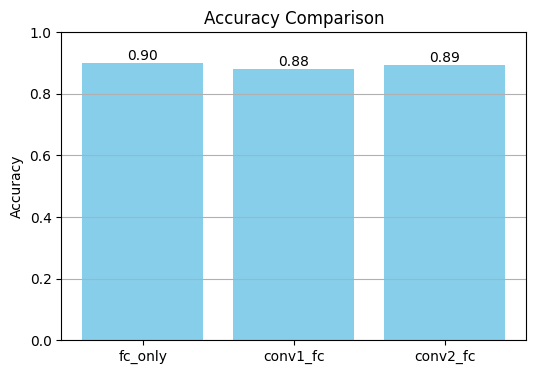

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color='skyblue')
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')
plt.show()


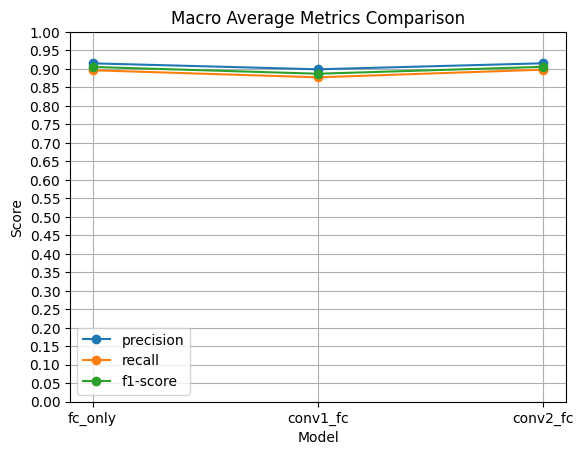

In [ ]:
import matplotlib.pyplot as plt

metrics = ["precision", "recall", "f1-score"]

for metric in metrics:
    values = [report["macro avg"][metric] for report in reports]
    plt.plot(model_names, values, marker='o', label=metric)

plt.title("Macro Average Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xlabel("Model")
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, 1.05, 0.05))  # Ticks from 0 to 1 with 0.05 step
plt.show()


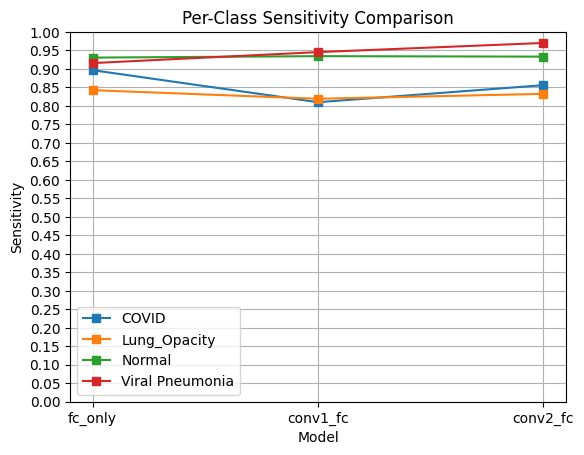

In [ ]:
for i, class_name in enumerate(["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]):
    values = [s[i] for s in sensitivities]
    plt.plot(model_names, values, marker='s', label=class_name)

plt.title("Per-Class Sensitivity Comparison")
plt.ylabel("Sensitivity")
plt.ylim(0, 1)
plt.xlabel("Model")
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, 1.05, 0.05))  # Ticks from 0 to 1 with 0.05 step

plt.show()


In [ ]:
evaluate_model(model_fc, val_ds, class_names=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"])


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━

In [ ]:
evaluate_model(model_c1, val_ds, class_names=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"])


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━

In [ ]:
evaluate_model(model_c2, val_ds, class_names=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"])


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 